In [28]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.impute import SimpleImputer  
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.impute import KNNImputer 
from sklearn.metrics import f1_score as calculate_f1_score

# Read the math placement data from the Excel file
df_math_placement = pd.read_excel('math_placement2024-02-29.xlsx')

# Read the edready raw scores data from the CSV file
df_ed_ready = pd.read_csv('edready_raw_scores.csv')

# Load the file of incoming students
#incoming_students = pd.read_csv('incoming_students.csv')will need to change to correct file name


In [29]:
# Create a new dataframe to store the cleaned and imputed data
df_cleaned = df_math_placement.copy()

# Define the mapping of grades to grade categories
grade_mapping = {
    "A": "Successful", 
    "B": "Successful", 
    "B+": "Successful",
    "A-": "Successful", 
    "B*": "Successful", 
    "A*": "Successful",
    "B+*": "Successful", 
    "W": "Unsuccessful", 
    "C-": "Unsuccessful",
    "F": "Unsuccessful", 
    "B-": "Successful", 
    "C+": "Unsuccessful",
    "D": "Unsuccessful", 
    "D*": "Unsuccessful", 
    "C": "Unsuccessful",
    "W*": "Unsuccessful", 
    "P*": "Successful", 
    "C+*": "Unsuccessful",
    "F*": "Unsuccessful", 
    "D+": "Unsuccessful", 
    "P": "Successful",
    "C*": "Unsuccessful", 
    "A-*": "Successful", 
    "I": "Unsuccessful",
    "AU": "Ignore", 
    "B-*": "Successful",
    "D-": "Unsuccessful",
    "NR": "Ignore", 
    "C-*": "Unsuccessful", 
    "I*": "Unsuccessful",
    "NR*": "Ignore"
}

# Map the grades to their categories and append as a new column
df_cleaned['grade_category'] = df_cleaned['grade'].map(grade_mapping)

# Define base courses and adjust the list based on 'campus_code'
base_courses = ['088', '216Q', '132', '161Q', '151Q', '165Q', '171Q']
courses_to_check = ['105Q', '090', '121Q']

# Define course combinations
course_combinations = {
    'Combo1': ('005', '105Q'),
    'Combo2': ('063', '090'),
    'Combo3': ('021', '121Q')
}

# Define a function to determine the course number or combo based on the course number and campus code
def determine_course_number(course_number, campus_code):
    if campus_code == 'ZGC' and course_number in courses_to_check:
        # Handle special cases for '105Q', '090', '121Q' based on 'campus_code'
        for combo_name, combo_courses in course_combinations.items():
            if course_number in combo_courses:
                # Return the combo name as the updated course number
                return combo_name
    elif course_number in base_courses or course_number in courses_to_check:
        # Return the original course number for base courses and courses_to_check
        return course_number
    # Return None for other courses to indicate they should be removed
    return None

# Apply the function to each row in df_cleaned to create a new 'course_number_updated' column
df_cleaned['course_number_updated'] = df_cleaned.apply(lambda row: determine_course_number(row['course_number'], row['campus_code']), axis=1)

# Drop rows where the course number is None
df_cleaned = df_cleaned.dropna(subset=['course_number_updated'])

# Define a dictionary to map course numbers to their corresponding course levels
course_level_mapping = {
    '088': 100,
    '090': 150,
    '105Q': 290,
    '121Q': 300,
    '132': 300,
    '151Q': 400,
    '161Q': 400,
    '165Q': 500,
    '171Q': 500,
    '216Q': 300,
    'Combo1': 150,
    'Combo2': 100,
    'Combo3': 250
}

# Function to map course number to course level
def map_course_level(course_number):
    return course_level_mapping.get(course_number, None)

# Apply the mapping function to create a new column 'course_level'
df_cleaned['course_level'] = df_cleaned['course_number_updated'].apply(map_course_level)


# Make sure the column names match in both dataframes before merging
df_cleaned.rename(columns={'pidm': 'PIDM'}, inplace=True)

# Create a new column to store the PIDM, course number, and term as a single string
df_cleaned['PIDM_course_number_term'] = df_cleaned['PIDM'].astype(str) + '_' + df_cleaned['course_number'].astype(str) + '_' + df_cleaned['term'].astype(str)

# Remove duplicates based on the new column
df_cleaned = df_cleaned.drop_duplicates(subset='PIDM_course_number_term')

# Display the cleaned and imputed dataframe
df_cleaned.head()






,Unnamed: 0,PIDM,term_code,gid,admit_term,degree.x,major_code,college.x,major.x,stu_type,...,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category,course_number_updated,course_level,PIDM_course_number_term
7,29,149852,202070,-110755,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,...,M,L,UG,4,RE,B*,Successful,Combo2,100,149852_090_202270
9,35,210982,202030,-171885,202030.0,Associate of Science,AS,Gallatin College,Associate of Science,N,...,STAT,L,UG,3,RW,B,Successful,216Q,300,210982_216Q_202170
11,39,324739,202130,-1053980,202130.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,...,M,L,UG,3,RW,A,Successful,105Q,290,324739_105Q_202270
13,43,372115,202170,-1097291,202170.0,Bachelor of Science,FNSC,College of Education/HHD,Food and Nutrition,T,...,M,L,UG,4,RW,A-,Successful,161Q,400,372115_161Q_202170
14,46,376132,202170,-1100963,202170.0,Bachelor of Science,PBAC,College of Business,Pre-Business,T,...,M,L,UG,4,RW,B+*,Successful,Combo2,100,376132_090_202230


In [30]:

# Convert 'term' to a numeric type to ensure correct sorting
df_cleaned['term'] = pd.to_numeric(df_cleaned['term'])

# Find the oldest term for each PIDM
oldest_terms = df_cleaned.groupby('PIDM')['term'].min().reset_index()

# Merge the oldest terms back to the original DataFrame to filter records
df_oldest = pd.merge(df_cleaned, oldest_terms, on=['PIDM', 'term'], how='inner')

# Now, df_oldest contains only the records of the oldest term for each PIDM,
# including cases where there are multiple records for a PIDM within that oldest term

# Sort PIDM
df_oldest.sort_values(by=['PIDM', 'term'], ascending=[True, True], inplace=True)

# Show the updated DataFrame
df_oldest.head()


,Unnamed: 0,PIDM,term_code,gid,admit_term,degree.x,major_code,college.x,major.x,stu_type,...,subj_code,section_type,credit_levl,course_credits,reg_status,grade,grade_category,course_number_updated,course_level,PIDM_course_number_term
0,29,149852,202070,-110755,202070.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,...,M,L,UG,4,RE,B*,Successful,Combo2,100,149852_090_202270
1,35,210982,202030,-171885,202030.0,Associate of Science,AS,Gallatin College,Associate of Science,N,...,STAT,L,UG,3,RW,B,Successful,216Q,300,210982_216Q_202170
2,39,324739,202130,-1053980,202130.0,Associate of Arts,AA,Gallatin College,Associate of Arts,T,...,M,L,UG,3,RW,A,Successful,105Q,290,324739_105Q_202270
3,43,372115,202170,-1097291,202170.0,Bachelor of Science,FNSC,College of Education/HHD,Food and Nutrition,T,...,M,L,UG,4,RW,A-,Successful,161Q,400,372115_161Q_202170
4,46,376132,202170,-1100963,202170.0,Bachelor of Science,PBAC,College of Business,Pre-Business,T,...,M,L,UG,4,RW,B+*,Successful,Combo2,100,376132_090_202230


In [31]:
# Trim whitespace from headers
df_oldest.columns = df_oldest.columns.str.strip()
df_ed_ready.columns = df_ed_ready.columns.str.strip()

# Merge the two dataframes based on the PIDM
df_merged = pd.merge(df_oldest, df_ed_ready[['PIDM', 'ERM_SCORE']], on='PIDM', how='left')


# Display the merged dataframe
df_merged .head()

# Save the compliant records to a CSV file
df_merged.to_csv('cleaned_merged_output.csv', index=False)

In [32]:
# Define thresholds for single scores
erm_score_thresholds = {
    100: 10,
    150: 15,
    250: 25,
    290: 30,
    300: 30,
    400: 40,
    500: 50,
}

# Define thresholds for SAT and ACT as tuples (min, max)
sat_new_math_thresholds = {
    100: (None, 460),
    150: (460, 529),
    250: (530, 539),
    290: (540, 559),
    300: (560, 589),
    400: (590, 639),
    500: (640, 640),
}
act_math_thresholds = {
    100: (None, 17),
    150: (17, 20),
    250: (21, 21),
    290: (22, 22),
    300: (23, 24),
    400: (25, 26),
    500: (27, 27),
}

# Define dual thresholds for SAT new math and high school GPA
dual_sat_gpa_thresholds = {
    150: (380, 519, None, 3.0),
    250: (520, 529, 3.01, 3.5),
    290: (530, 530, 3.01, 3.5),
    300: (530, 559, 3.01, 3.5),
    400: (560, 580, 3.7, 4.5),
}

# Define dual thresholds for ACT math and high school GPA
dual_act_gpa_thresholds = {
    150: (15, 19, None, 3.0),
    250: (20, 20, 3.01, 3.5),
    290: (21, 21, 3.01, 3.5),
    300: (21, 22, 3.01, 3.5),
    400: (23, 24, 3.7, 4.5),
}
# Compliance checking function with the specified order
def check_compliance(row):
    level = row['course_level']
    
    # Flag to track compliance with each parameter
    compliance_flags = {
        'sat_new_math': False,
        'act_math': False,
        'hs_gpa': False,
        'ERM_SCORE': False
    }
    
    # Check SAT new math compliance if it exists and isn't NaN
    sat_new_math = row.get('sat_new_math', None)
    if not pd.isna(sat_new_math):
        sat_thresholds = sat_new_math_thresholds.get(level, (None, None))
        if (sat_thresholds[0] is None or sat_new_math >= sat_thresholds[0]) and \
           (sat_thresholds[1] is None or sat_new_math <= sat_thresholds[1]):
            compliance_flags['sat_new_math'] = True

    # Check ACT math compliance if it exists and isn't NaN
    act_math = row.get('act_math', None)
    if not pd.isna(act_math):
        act_thresholds = act_math_thresholds.get(level, (None, None))
        if (act_thresholds[0] is None or act_math >= act_thresholds[0]) and \
           (act_thresholds[1] is None or act_math <= act_thresholds[1]):
            compliance_flags['act_math'] = True

    # Check high school GPA compliance if it exists and isn't NaN
    hs_gpa = row.get('hs_gpa', None)
    if not pd.isna(hs_gpa):
        if hs_gpa >= 3.0:  # Assuming a minimum GPA of 3.0 is compliant
            compliance_flags['hs_gpa'] = True

    # Check ERM_SCORE compliance if it exists and isn't NaN
    erm_score = row.get('ERM_SCORE', None)
    if not pd.isna(erm_score):
        erm_threshold = erm_score_thresholds.get(level, None)
        if erm_threshold is None or erm_score >= erm_threshold:
            compliance_flags['ERM_SCORE'] = True
    
    # Check if any of the compliance flags are True
    if any(compliance_flags.values()):
        return 'Compliant'
    else:
        return 'Uncompliant'

# Apply the compliance checking function to each row
df_merged['Compliance'] = df_merged.apply(check_compliance, axis=1)

# Display the result
print(df_merged[['course_level', 'sat_new_math', 'hs_gpa', 'act_math', 'ERM_SCORE', 'Compliance']])

# Save the result to a CSV file
df_merged[['course_level', 'ERM_SCORE', 'sat_new_math', 'act_math', 'hs_gpa', 'Compliance','course_number_updated']].to_csv('compliant.csv', index=False)


       course_level  sat_new_math  hs_gpa  act_math  ERM_SCORE   Compliance
0               100           NaN    1.72       NaN       10.0    Compliant
1               300           NaN    2.50       NaN        NaN  Uncompliant
2               290           NaN     NaN       NaN       30.0    Compliant
3               400           NaN     NaN       NaN       40.0    Compliant
4               100           NaN     NaN       NaN       10.0    Compliant
...             ...           ...     ...       ...        ...          ...
12721           400           NaN     NaN       NaN       30.0  Uncompliant
12722           300           NaN     NaN       NaN       30.0    Compliant
12723           300           NaN     NaN       NaN       40.0    Compliant
12724           300           NaN    3.00       NaN       30.0    Compliant
12725           250           NaN    4.30      20.0        NaN    Compliant

[12726 rows x 6 columns]


In [33]:
# Count the occurrences of each grade category
grade_counts = df_merged['grade_category'].value_counts()

# Display the count of each grade category
print(grade_counts)

# Count the number of rows in the merged dataframe
num_rows = df_merged.shape[0]
print(f"Number of rows in df_merged: {num_rows}")


grade_category
Successful      7250
Unsuccessful    5450
Ignore            25
Name: count, dtype: int64
Number of rows in df_merged: 12726


In [34]:

# If compliance is 'Compliant' count the number of rows in the merged dataframe
df_comp = df_merged[df_merged['Compliance'] == 'Compliant']


# Count the occurrences of each grade category
grade_counts = df_comp['grade_category'].value_counts()

# Display the count of each grade category
print(grade_counts)

# Count the number of rows in the comp dataframe
num_rows = df_comp.shape[0]
print(f"Number of rows in df_comp: {num_rows}")

grade_category
Successful      6626
Unsuccessful    4652
Ignore             2
Name: count, dtype: int64
Number of rows in df_comp: 11280


In [35]:


# Group by 'course_level' and then count occurrences of each 'grade_category' within each level
grade_category_distribution = df_comp.groupby('course_level')['grade_category'].value_counts().unstack(fill_value=0)


# Add a new column to store the ratio of successful students
grade_category_distribution['successful_ratio'] = grade_category_distribution['Successful'] / (grade_category_distribution['Ignore'] + grade_category_distribution['Successful'] + grade_category_distribution['Unsuccessful'])


# Display the distribution of grade categories within each course level
print(grade_category_distribution)





grade_category  Ignore  Successful  Unsuccessful  successful_ratio
course_level                                                      
100                  0         894           681          0.567619
150                  0         230           176          0.566502
250                  0         340           426          0.443864
290                  1         292           118          0.710462
300                  1        2261          1924          0.540134
400                  0        1886           947          0.665725
500                  0         723           380          0.655485


In [36]:
# Group by 'course_number' and then count occurrences of each 'grade_category' within each level
grade_category_distribution = df_comp.groupby('course_number_updated')['grade_category'].value_counts().unstack(fill_value=0)

# Add a new column to store the ratio of successful students
grade_category_distribution['successful_ratio'] = grade_category_distribution['Successful'] / (grade_category_distribution['Ignore'] + grade_category_distribution['Successful'] + grade_category_distribution['Unsuccessful'])

# Display the distribution of grade categories within each course number
print(grade_category_distribution)



grade_category         Ignore  Successful  Unsuccessful  successful_ratio
course_number_updated                                                    
088                         0          61            62          0.495935
090                         0          47            49          0.489583
105Q                        1         292           118          0.710462
121Q                        1        1044          1153          0.474977
132                         0         114            39          0.745098
151Q                        0         852           444          0.657407
161Q                        0        1034           503          0.672739
165Q                        0          40            29          0.579710
171Q                        0         683           351          0.660542
216Q                        0        1103           732          0.601090
Combo1                      0         183           127          0.590323
Combo2                      0         

In [37]:
# Fill in missing values with NaN and convert to numeric using .loc
df_comp.loc[:, 'ERM_SCORE'] = pd.to_numeric(df_merged['ERM_SCORE'], errors='coerce')

# Exclude 0s
df_comp_filtered = df_comp[df_comp['ERM_SCORE'] != 0]



# Statistical output of the filtered DataFrame
df_comp_filtered[['hs_gpa', 'act_math', 'sat_new_math', 'ERM_SCORE', 'course_level', 'grade_category']].describe()


,hs_gpa,act_math,sat_new_math,ERM_SCORE,course_level
count,10664.000000,5094.000000,3040.000000,5120.000000,11280.000000
mean,3.516091,22.616608,572.546053,28.780273,307.587766
std,0.467294,4.560698,75.781100,10.037611,113.731283
min,1.290000,12.000000,300.000000,10.000000,100.000000
25%,3.250000,19.000000,530.000000,25.000000,290.000000
50%,3.620000,23.000000,570.000000,30.000000,300.000000
75%,3.900000,26.000000,620.000000,40.000000,400.000000
max,4.850000,36.000000,800.000000,40.000000,500.000000


### Model 1: Logistic Regression Model - Courses/Combos

In [38]:
# Filter out rows where 'grade_category' is 'Ignore'
df_comp = df_merged[df_merged['grade_category'] != 'Ignore']

# Combine individual courses with combination labels for iteration
included_courses = df_comp['course_number_updated'].unique()

label_encoder = LabelEncoder()

# Fit the LabelEncoder only on the filtered DataFrame's 'grade_category'
label_encoder.fit(df_comp['grade_category'].unique())


# Filtering DataFrame based on updated logic
def filter_df(df, course_key):
    # For combinations, select rows matching any of the combination courses
    if course_key in course_combinations:
        return df[df['course_number'].isin(course_combinations[course_key])]
    # For individual courses, simply filter by the course number
    else:
        return df[df['course_number'] == course_key]


# Define the combinations of X variables you want to explore
x_variable_combinations = [
    ['ERM_SCORE'],
    ['hs_gpa', 'ERM_SCORE'],
    ['sat_new_math'],
    ['act_math'],
    ['hs_gpa', 'sat_new_math'],
    ['hs_gpa', 'act_math']
]

# Initialize model storage with an additional level for variable combinations
models = {}

for course_key in included_courses:
    df_filtered = filter_df(df_merged, course_key)
    
    # Make sure 'grade_category' only contains 'Successful' or 'Unsuccessful'
    df_filtered = df_filtered[df_filtered['grade_category'].isin(['Successful', 'Unsuccessful'])]

    if df_filtered.empty:
        print(f"No data for {course_key}")
        continue

    for x_vars in x_variable_combinations:
        X = df_filtered[x_vars].fillna(0)
        y = df_filtered['grade_category'].map({'Successful': 1, 'Unsuccessful': 0}).values

        
        # Check if the target variable has only one unique value
        unique_values = np.unique(y)
        
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)

        # Fit the statsmodels logistic regression model if it's binary
        if len(unique_values) == 2:
            sm_model = sm.Logit(y_train, X_train).fit(disp=0)
            print(f'Logit model summary for {course_key}:')
            print(sm_model.summary())

        # Fit the scikit-learn logistic regression model
        log_reg = LogisticRegression(max_iter=1000)
        try:
            # For sklearn, we don't use the intercept column, so we drop it
            log_reg.fit(X_train.drop('const', axis=1), y_train)
        except ValueError as e:
            print(f"Error fitting scikit-learn Logistic Regression for {course_key} with variables {x_vars}: {e}")
            continue

        try:
            y_pred = log_reg.predict(X_test.drop('const', axis=1))  # Exclude 'const' for prediction
        except ValueError as e:
            print(f"Error making predictions with scikit-learn Logistic Regression for {course_key} with variables {x_vars}: {e}")
            continue

        # Prediction and Evaluation
        unique_y_test = set(y_test)
        unique_y_pred = set(y_pred)
        unique_classes = unique_y_test.union(unique_y_pred)
        target_names = label_encoder.inverse_transform(list(unique_classes))
        print(f'Course Level: {course_key}, Variables: {x_vars}')
        print(classification_report(y_test, y_pred, labels=list(unique_classes), target_names=target_names, zero_division=1))
        print("--------------------\n")
                
        # Store the model
        models[(course_key, tuple(x_vars))] = log_reg
        
        
        


Logit model summary for Combo2:
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1166
Model:                          Logit   Df Residuals:                     1164
Method:                           MLE   Df Model:                            1
Date:                Mon, 08 Apr 2024   Pseudo R-squ.:                0.007894
Time:                        18:45:43   Log-Likelihood:                -787.37
converged:                       True   LL-Null:                       -793.63
Covariance Type:            nonrobust   LLR p-value:                 0.0004005
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5287      0.085      6.223      0.000       0.362       0.695
ERM_SCORE     -0.0293      0.008     -3.524      0.000      -0.046      -0.013
Course Level: Combo2

In [39]:
# Make sure stats_table is initialized correctly as a DataFrame
stats_table = pd.DataFrame(columns=['Course Level', 'Variables', 'Pseudo R-squared', 'Log-Likelihood', 'LLR p-value', 'LL-Null'])

for course_key in included_courses:
    df_filtered = filter_df(df_merged, course_key)
    
    # Ensure only 'Successful' or 'Unsuccessful' are considered
    df_filtered = df_filtered[df_filtered['grade_category'].isin(['Successful', 'Unsuccessful'])]

    if df_filtered.empty:
        continue

    for x_vars in x_variable_combinations:
        X = df_filtered[x_vars].fillna(0)
        y = df_filtered['grade_category'].map({'Successful': 1, 'Unsuccessful': 0}).values

        if len(np.unique(y)) < 2:
            continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
        X_train = sm.add_constant(X_train)

        sm_model = sm.Logit(y_train, X_train).fit(disp=0)
        
        # Extracting statistics
        pseudo_r_squared = sm_model.prsquared
        log_likelihood = sm_model.llf
        llr_pvalue = sm_model.llr_pvalue
        ll_null = sm_model.llnull  # Extracting the LL-Null
        
        # Create a temporary DataFrame for the current row of statistics
        temp_df = pd.DataFrame({
            'Course Level': [course_key],
            'Variables': [', '.join(x_vars)],
            'Pseudo R-squared': [pseudo_r_squared],
            'Log-Likelihood': [log_likelihood],
            'LLR p-value': [llr_pvalue],
            'LL-Null': [ll_null]  # Adding LL-Null to the DataFrame
        })
        
        # Concatenate the temporary DataFrame to the main stats_table DataFrame
        stats_table = pd.concat([stats_table, temp_df], ignore_index=True)

        # Continue with your logistic regression model fitting and predictions...

# Display or save the statistics table
print(stats_table)
# Optionally, save to CSV
stats_table.to_csv('model_statistics.csv', index=False)




C:\Users\britt\AppData\Local\Temp\ipykernel_25944\494661288.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_table = pd.concat([stats_table, temp_df], ignore_index=True)


   Course Level             Variables  Pseudo R-squared  Log-Likelihood  \
0        Combo2             ERM_SCORE          0.007894     -787.365834   
1        Combo2     hs_gpa, ERM_SCORE          0.018889     -778.640117   
2        Combo2          sat_new_math          0.001415     -792.507435   
3        Combo2              act_math          0.007340     -787.805615   
4        Combo2  hs_gpa, sat_new_math          0.012620     -783.615302   
..          ...                   ...               ...             ...   
73         165Q     hs_gpa, ERM_SCORE          0.006329      -41.352210   
74         165Q          sat_new_math          0.000006      -41.615351   
75         165Q              act_math          0.020174      -40.776067   
76         165Q  hs_gpa, sat_new_math          0.000237      -41.605737   
77         165Q      hs_gpa, act_math          0.021249      -40.731317   

     LLR p-value     LL-Null  
0   4.005107e-04 -793.630739  
1   3.087847e-07 -793.630739  
2   1.

## Model 2:  Decision Tree

In [47]:
# Transform the 'course_level' column to numeric values
course_number_encoder = LabelEncoder()

# Filter out rows where 'grade_category' is 'Ignore'
df_comp_copy= df_comp[df_comp['grade_category'] != 'Ignore'].copy()

# Encode the 'course_level' column
df_comp['encoded_course_level'] = course_number_encoder.fit_transform(df_comp['course_level'])

# Convert numpy array of integers to list of strings
target_names = [str(class_name) for class_name in course_number_encoder.classes_]

# Loop through each combination of predictor variables
for predictors in x_variable_combinations:
    # Predictors
    X = df_comp_copy[predictors]

    # Target variable is 'course_number_encoded'
    y_course_number = df_comp_copy['encoded_course_level']

    # Create an instance of KNNImputer with the desired number of neighbors
    knn_imputer = KNNImputer(n_neighbors=5)  

    # Replace NA values using KNN imputation
    X_imputed = knn_imputer.fit_transform(X)
    
    #Drop NA Values
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

    # Split the data into training and testing sets
    X_train, X_test, y_train_course_number, y_test_course_number = train_test_split(X, y_course_number, test_size=0.3, random_state=42)
    
    
    clf_course_number = DecisionTreeClassifier(
    max_depth=5,               # Limit the depth of the tree
    min_samples_split=40,      # Require at least 40 samples to split a node
    min_samples_leaf=20,       # Each leaf node must contain at least 20 samples
    max_leaf_nodes=15,         # Limit the total number of leaf nodes
    random_state=42)

    # Fit the classifier to the training data
    clf_course_number.fit(X_train, y_train_course_number)

    # Predict on the test data
    y_pred_course_number = clf_course_number.predict(X_test)
    
    
    
    # Calculate the F1 score
    f1_score_value = calculate_f1_score(y_test_course_number, y_pred_course_number, average='weighted')
    

    print(f"F1 Score for predictors {predictors}: {f1_score_value:.2f}")
    print(classification_report(y_test_course_number, y_pred_course_number, target_names=target_names, zero_division=0))
    
        # Print feature importances for the current model
    feature_importances = pd.Series(clf_course_number.feature_importances_, index=predictors)
    print("Feature Importances:")
    print(feature_importances.sort_values(ascending=False))
    print("\n")

    


C:\Users\britt\AppData\Local\Temp\ipykernel_25944\1949682621.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp['encoded_course_level'] = course_number_encoder.fit_transform(df_comp['course_level'])


F1 Score for predictors ['ERM_SCORE']: 0.33
              precision    recall  f1-score   support

         100       0.75      0.54      0.63       524
         150       0.00      0.00      0.00       133
         250       0.70      0.43      0.54       271
         290       0.00      0.00      0.00       163
         300       0.41      0.96      0.57      1388
         400       0.00      0.00      0.00       939
         500       0.00      0.00      0.00       393

    accuracy                           0.46      3811
   macro avg       0.27      0.28      0.25      3811
weighted avg       0.30      0.46      0.33      3811

Feature Importances:
ERM_SCORE    1.0
dtype: float64


F1 Score for predictors ['hs_gpa', 'ERM_SCORE']: 0.40
              precision    recall  f1-score   support

         100       0.75      0.54      0.63       524
         150       0.00      0.00      0.00       133
         250       0.70      0.43      0.54       271
         290       0.00      0.00

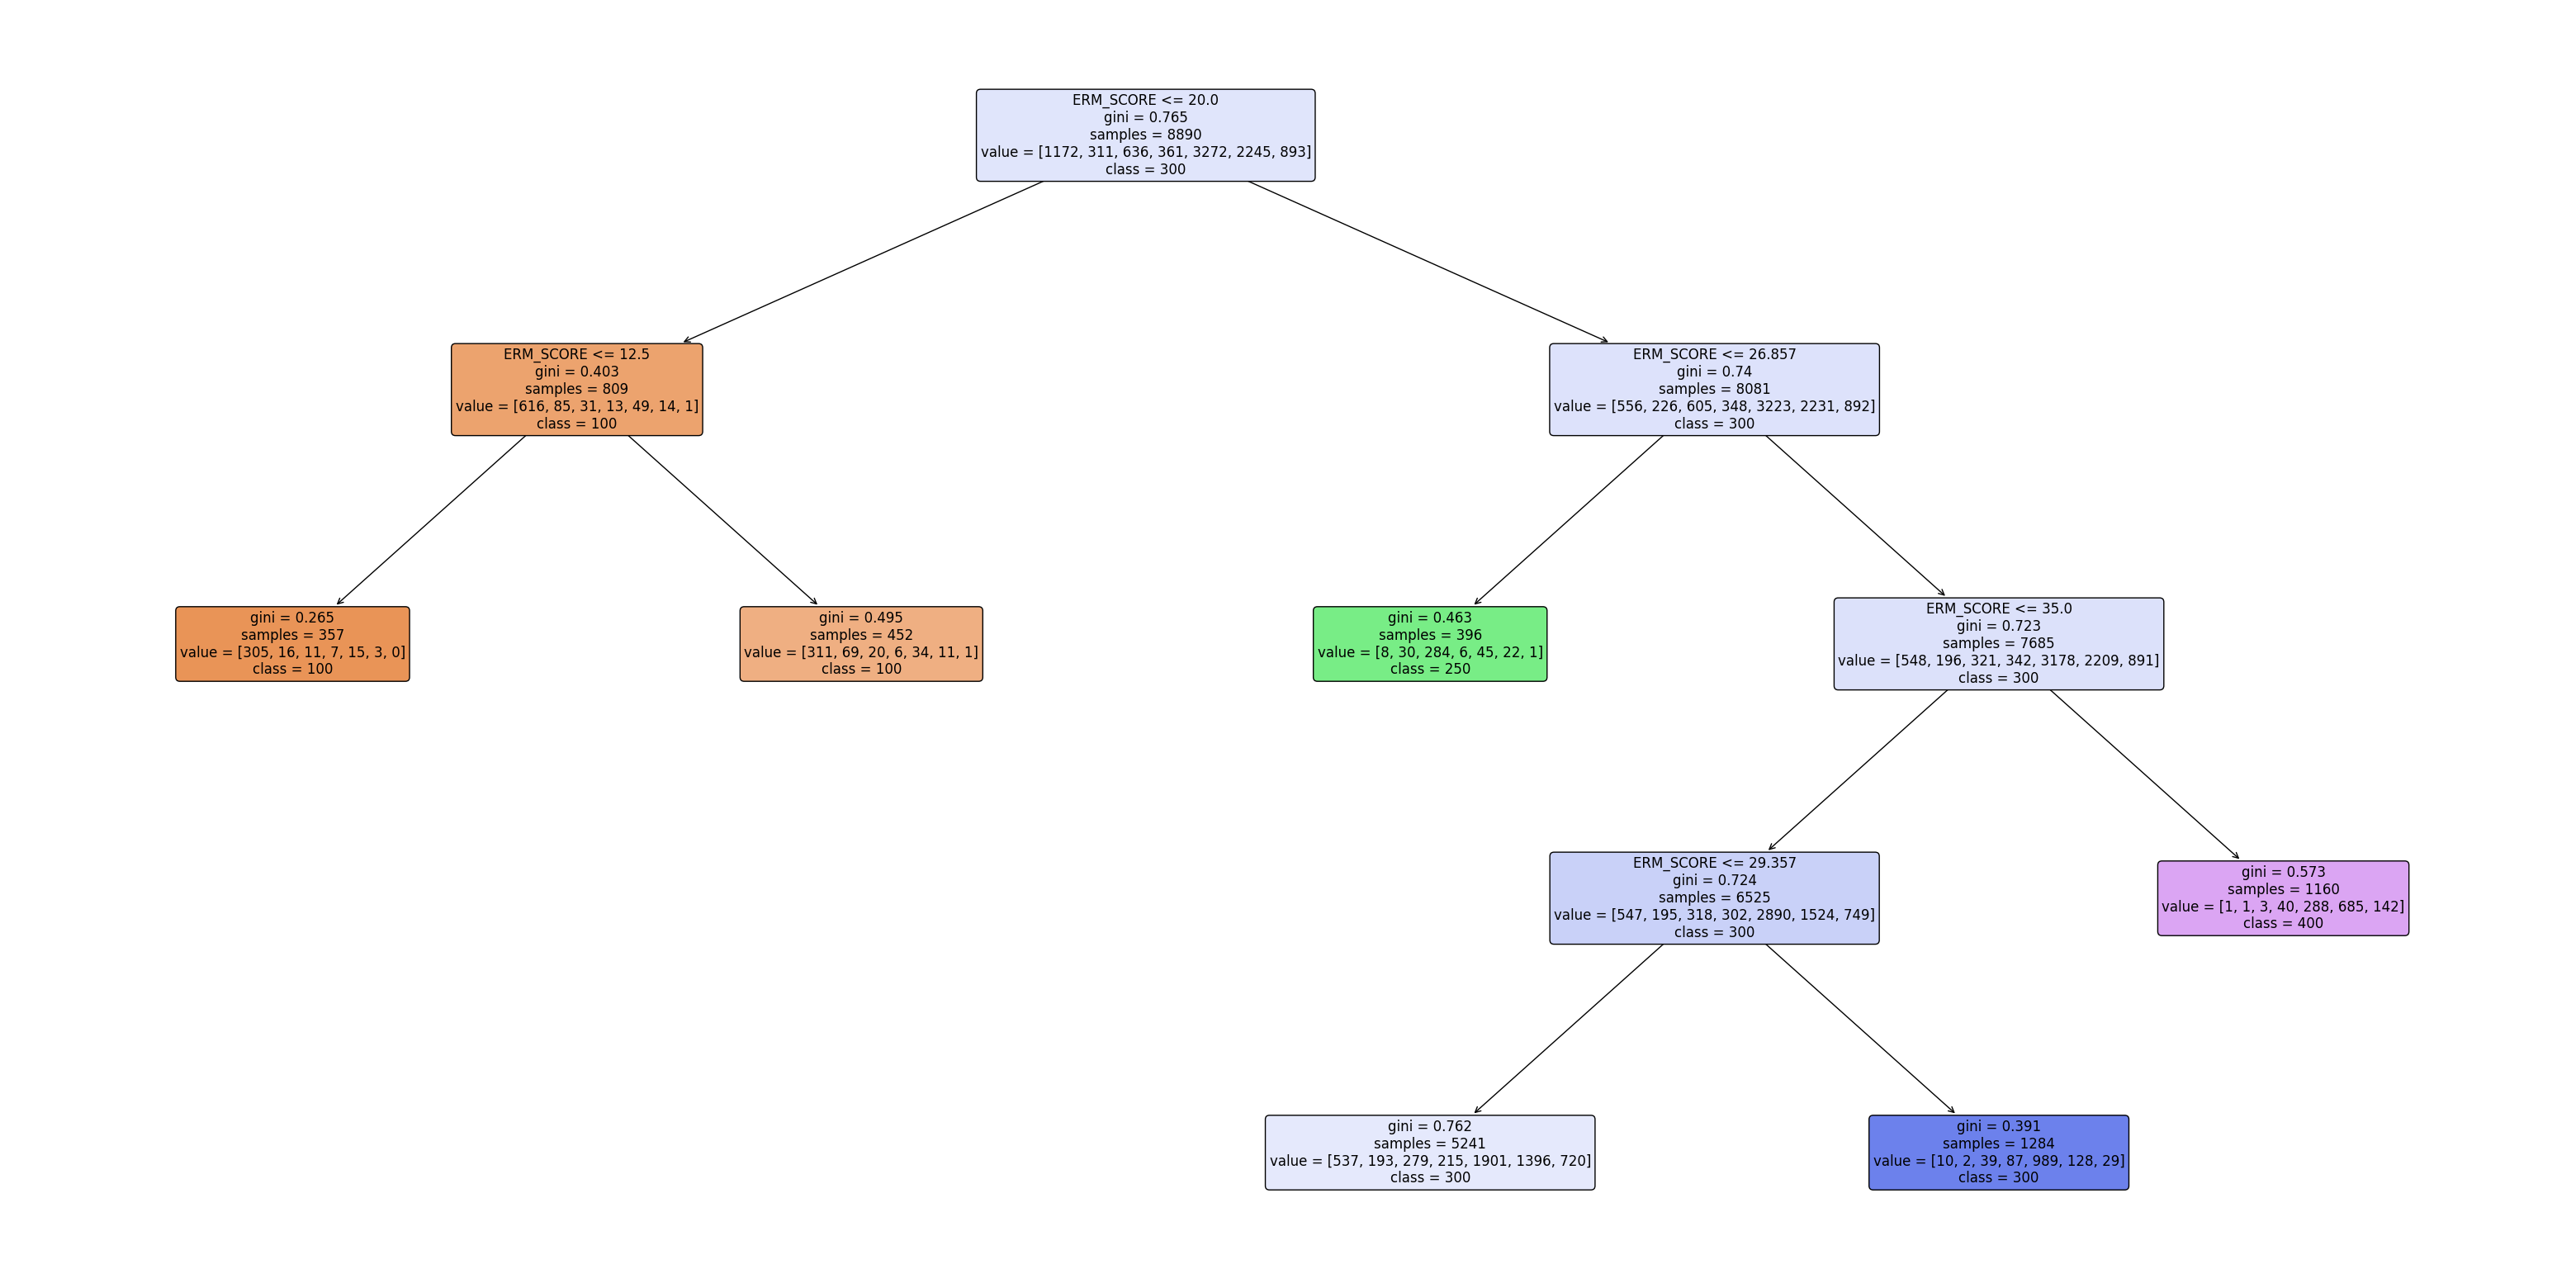

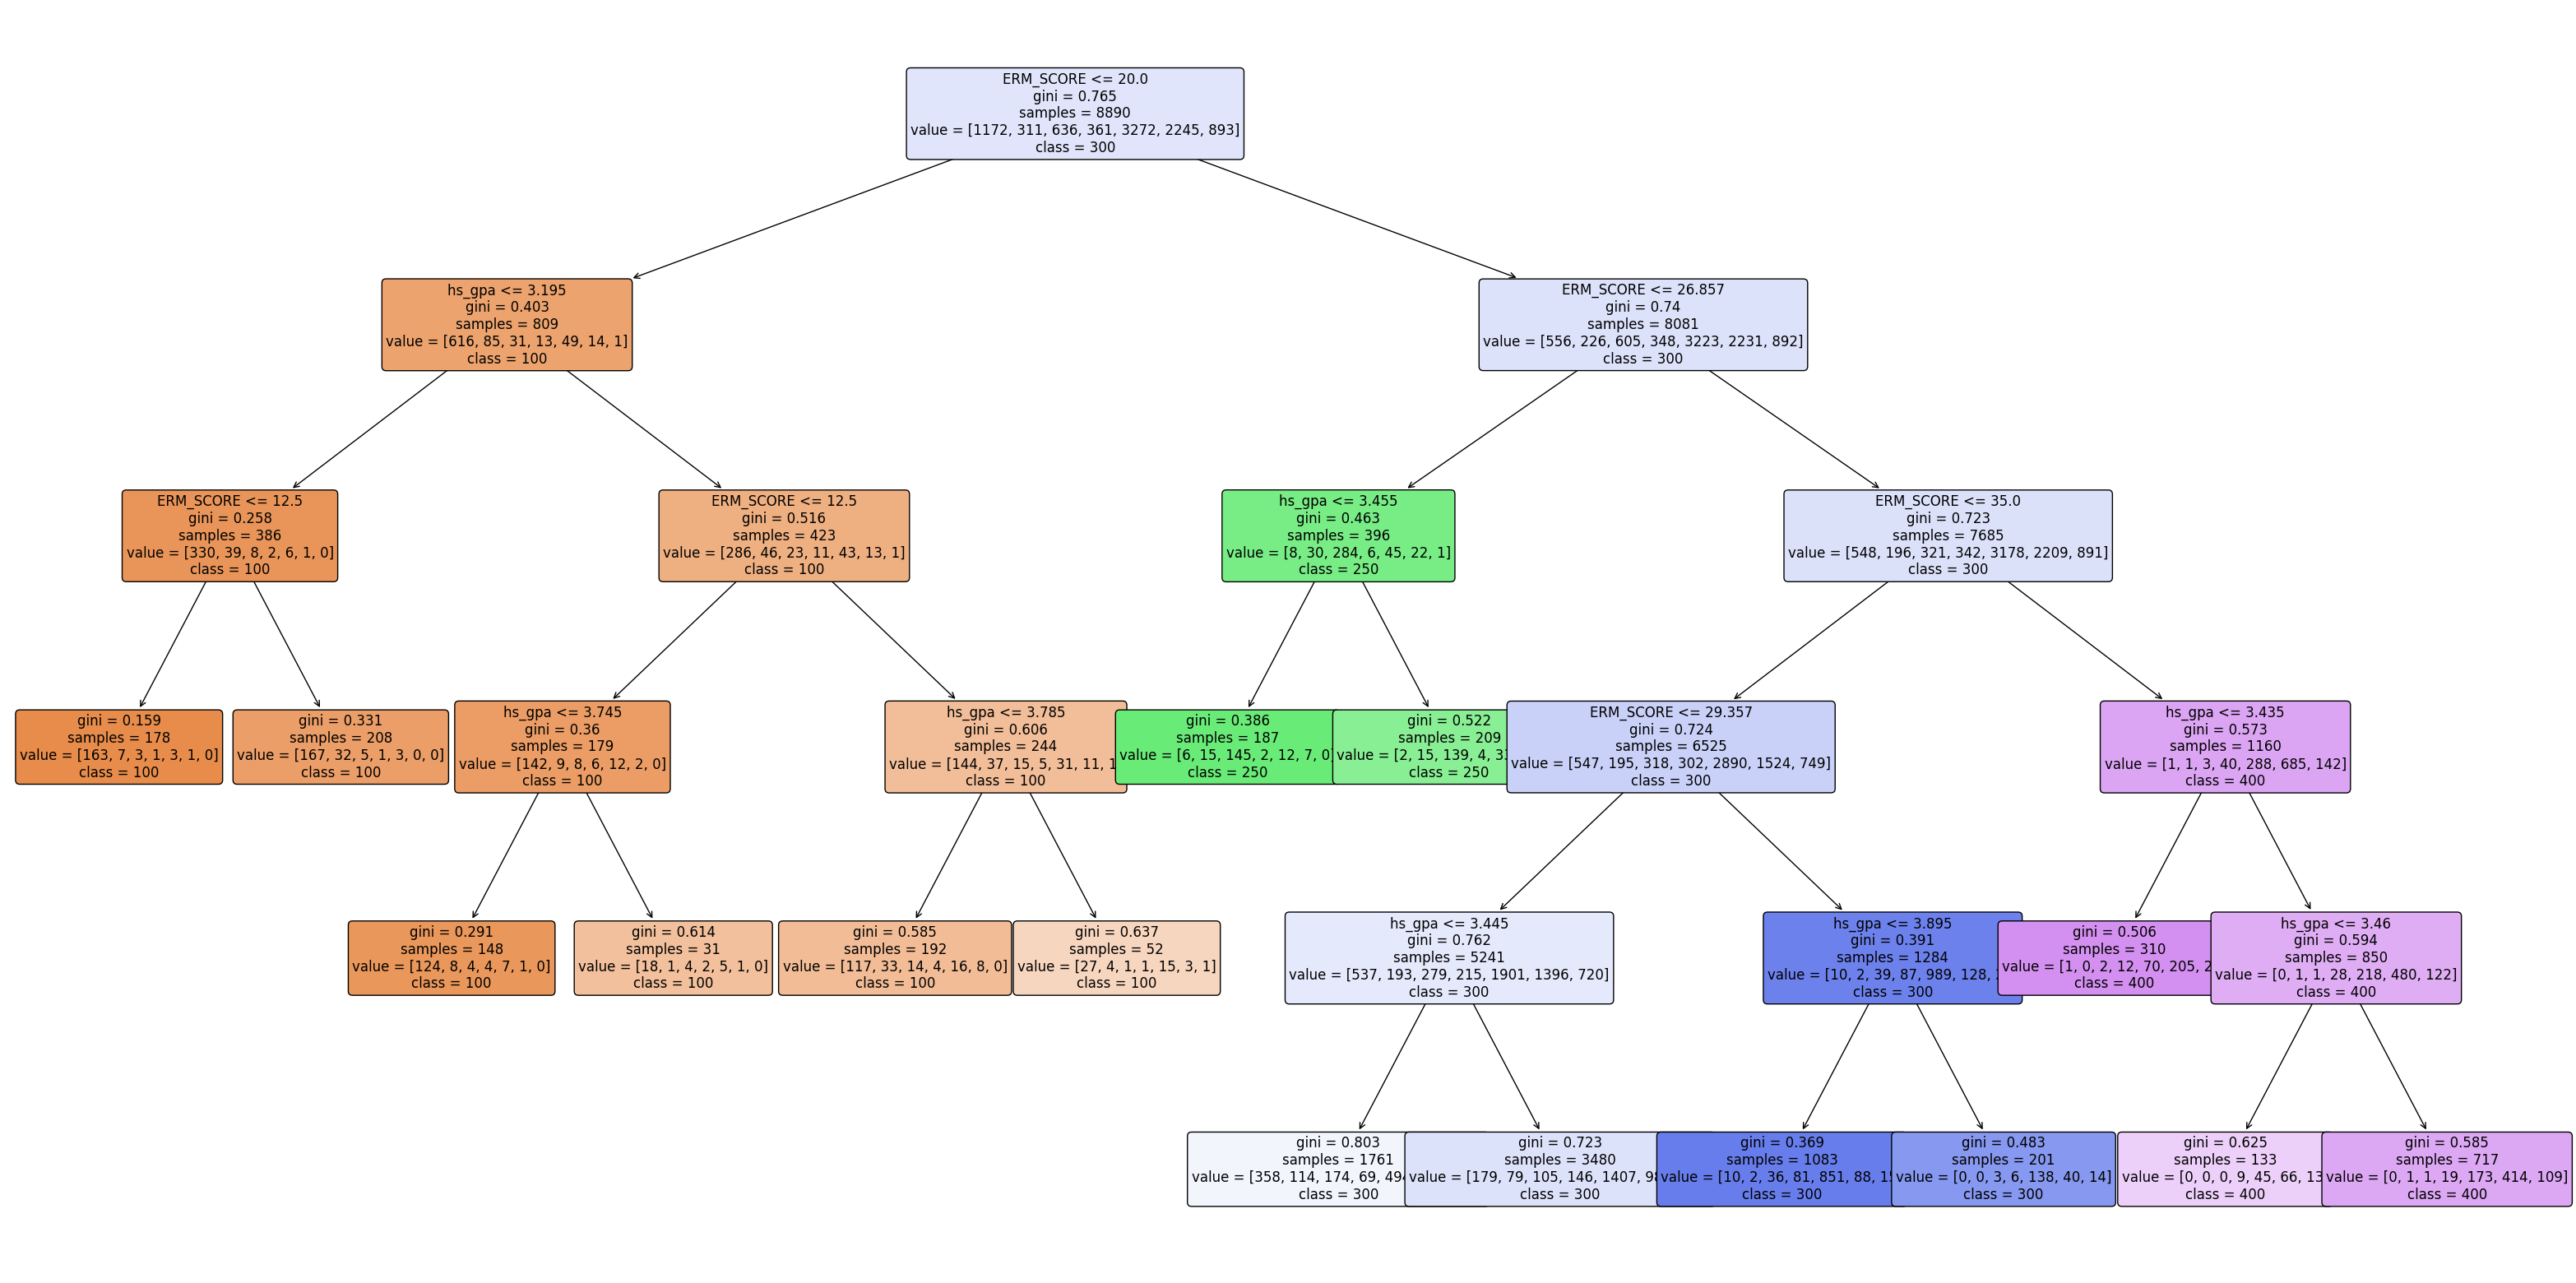

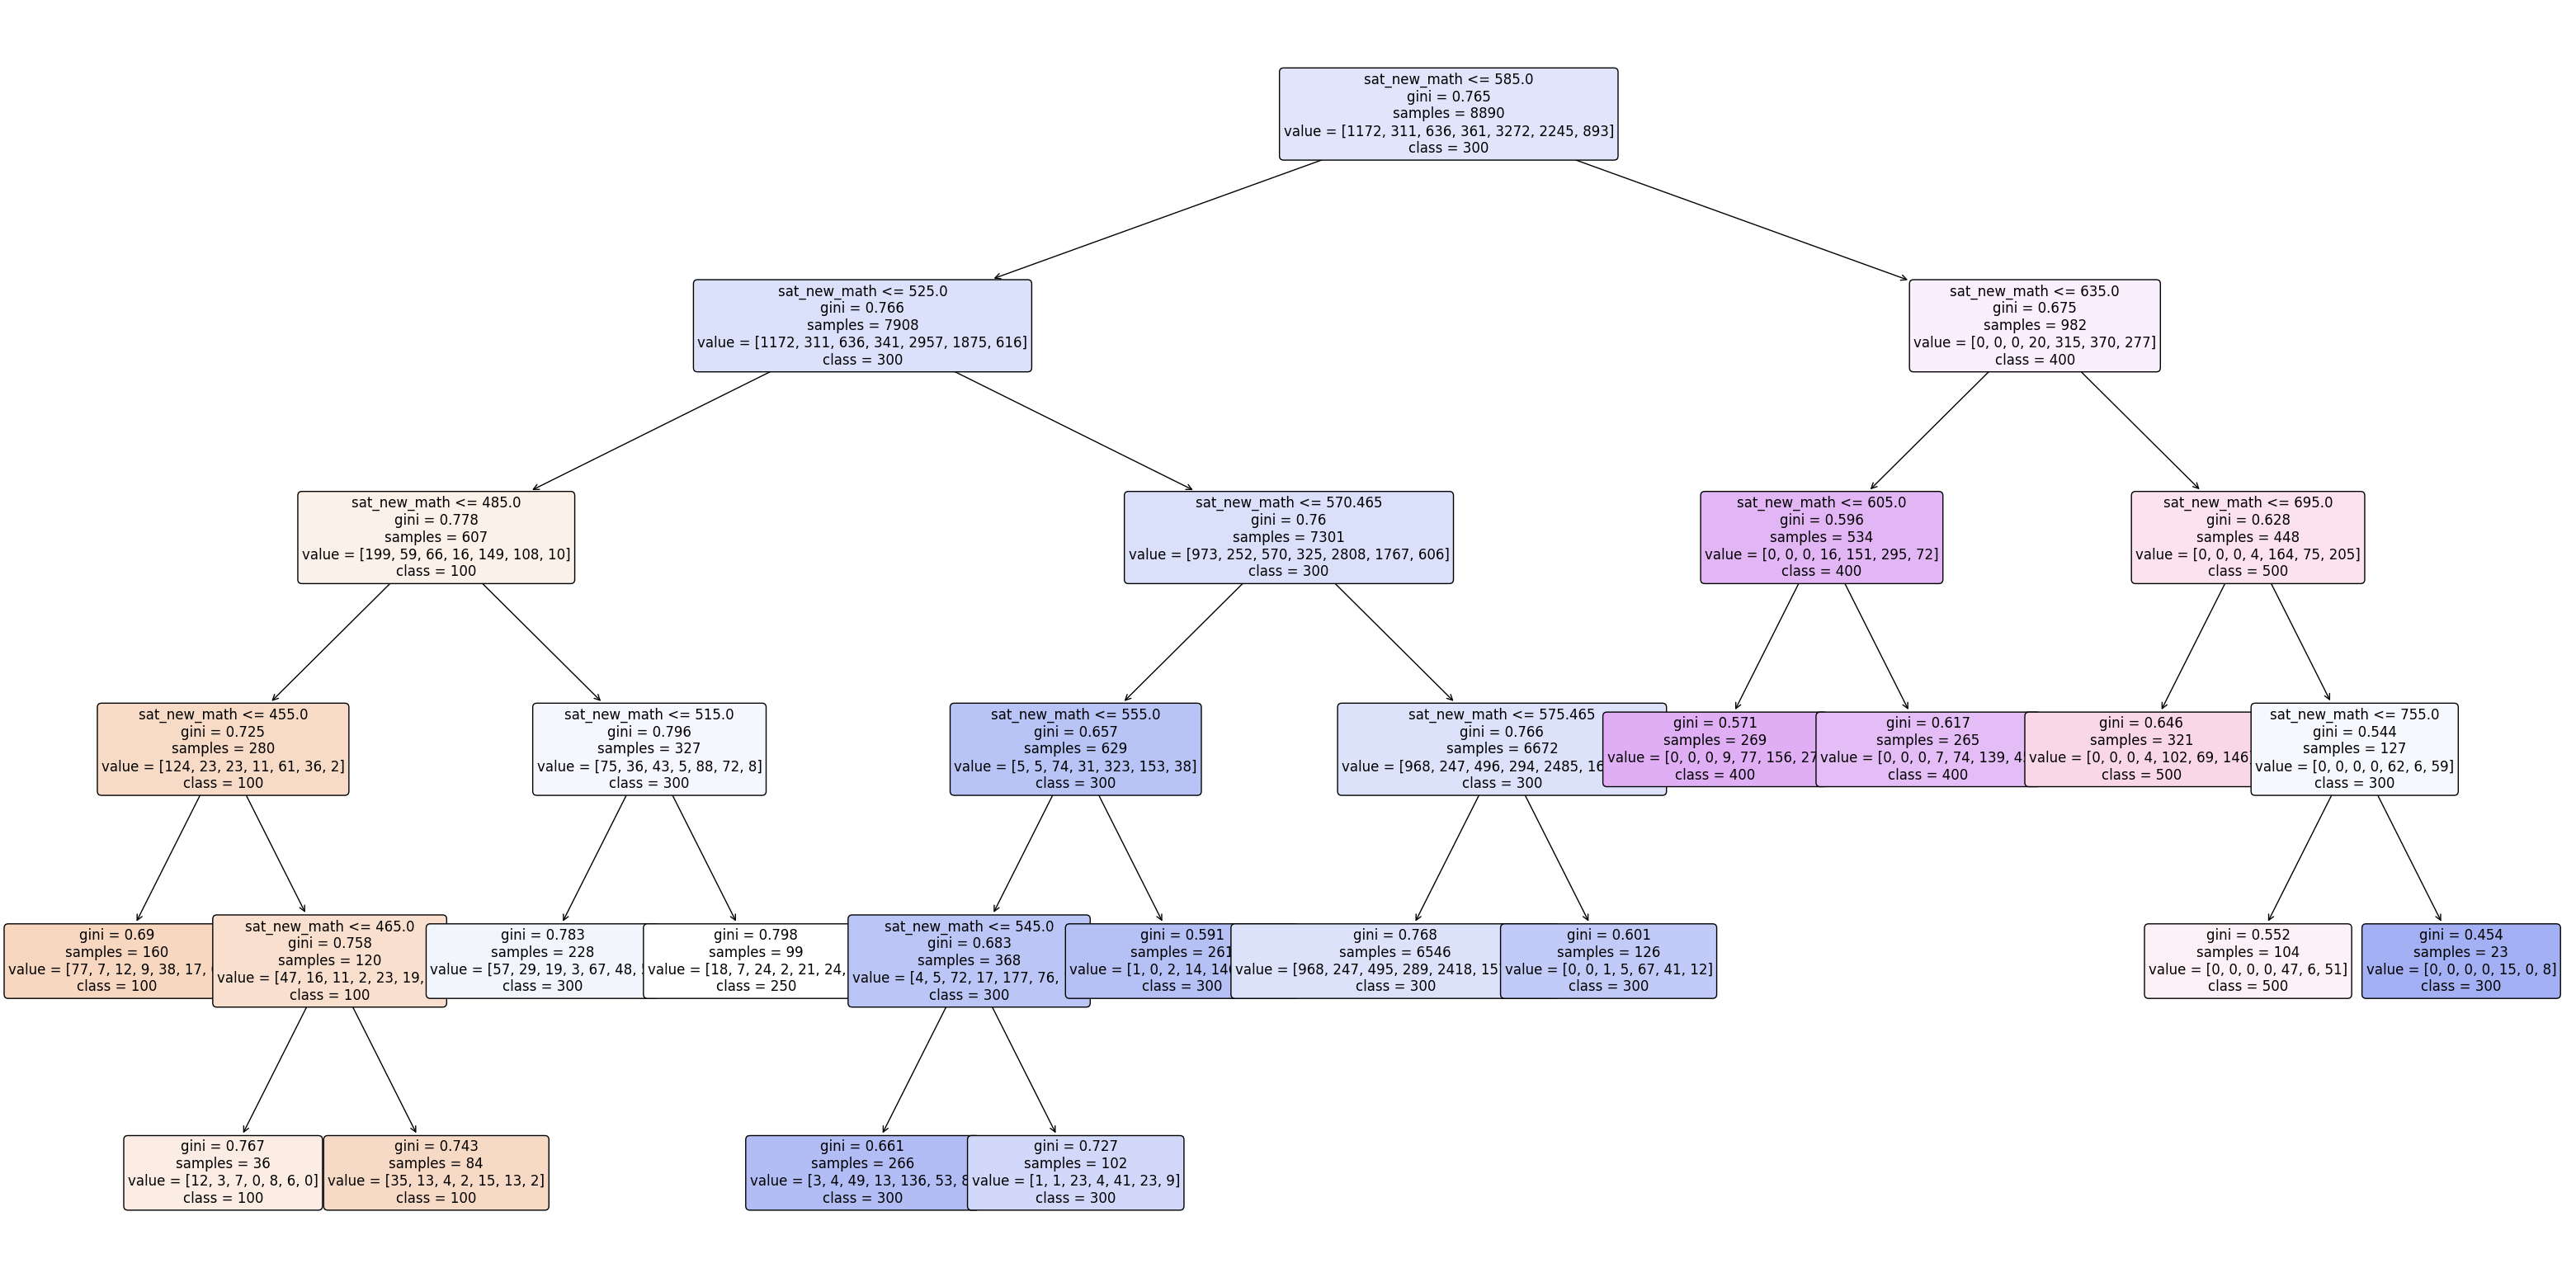

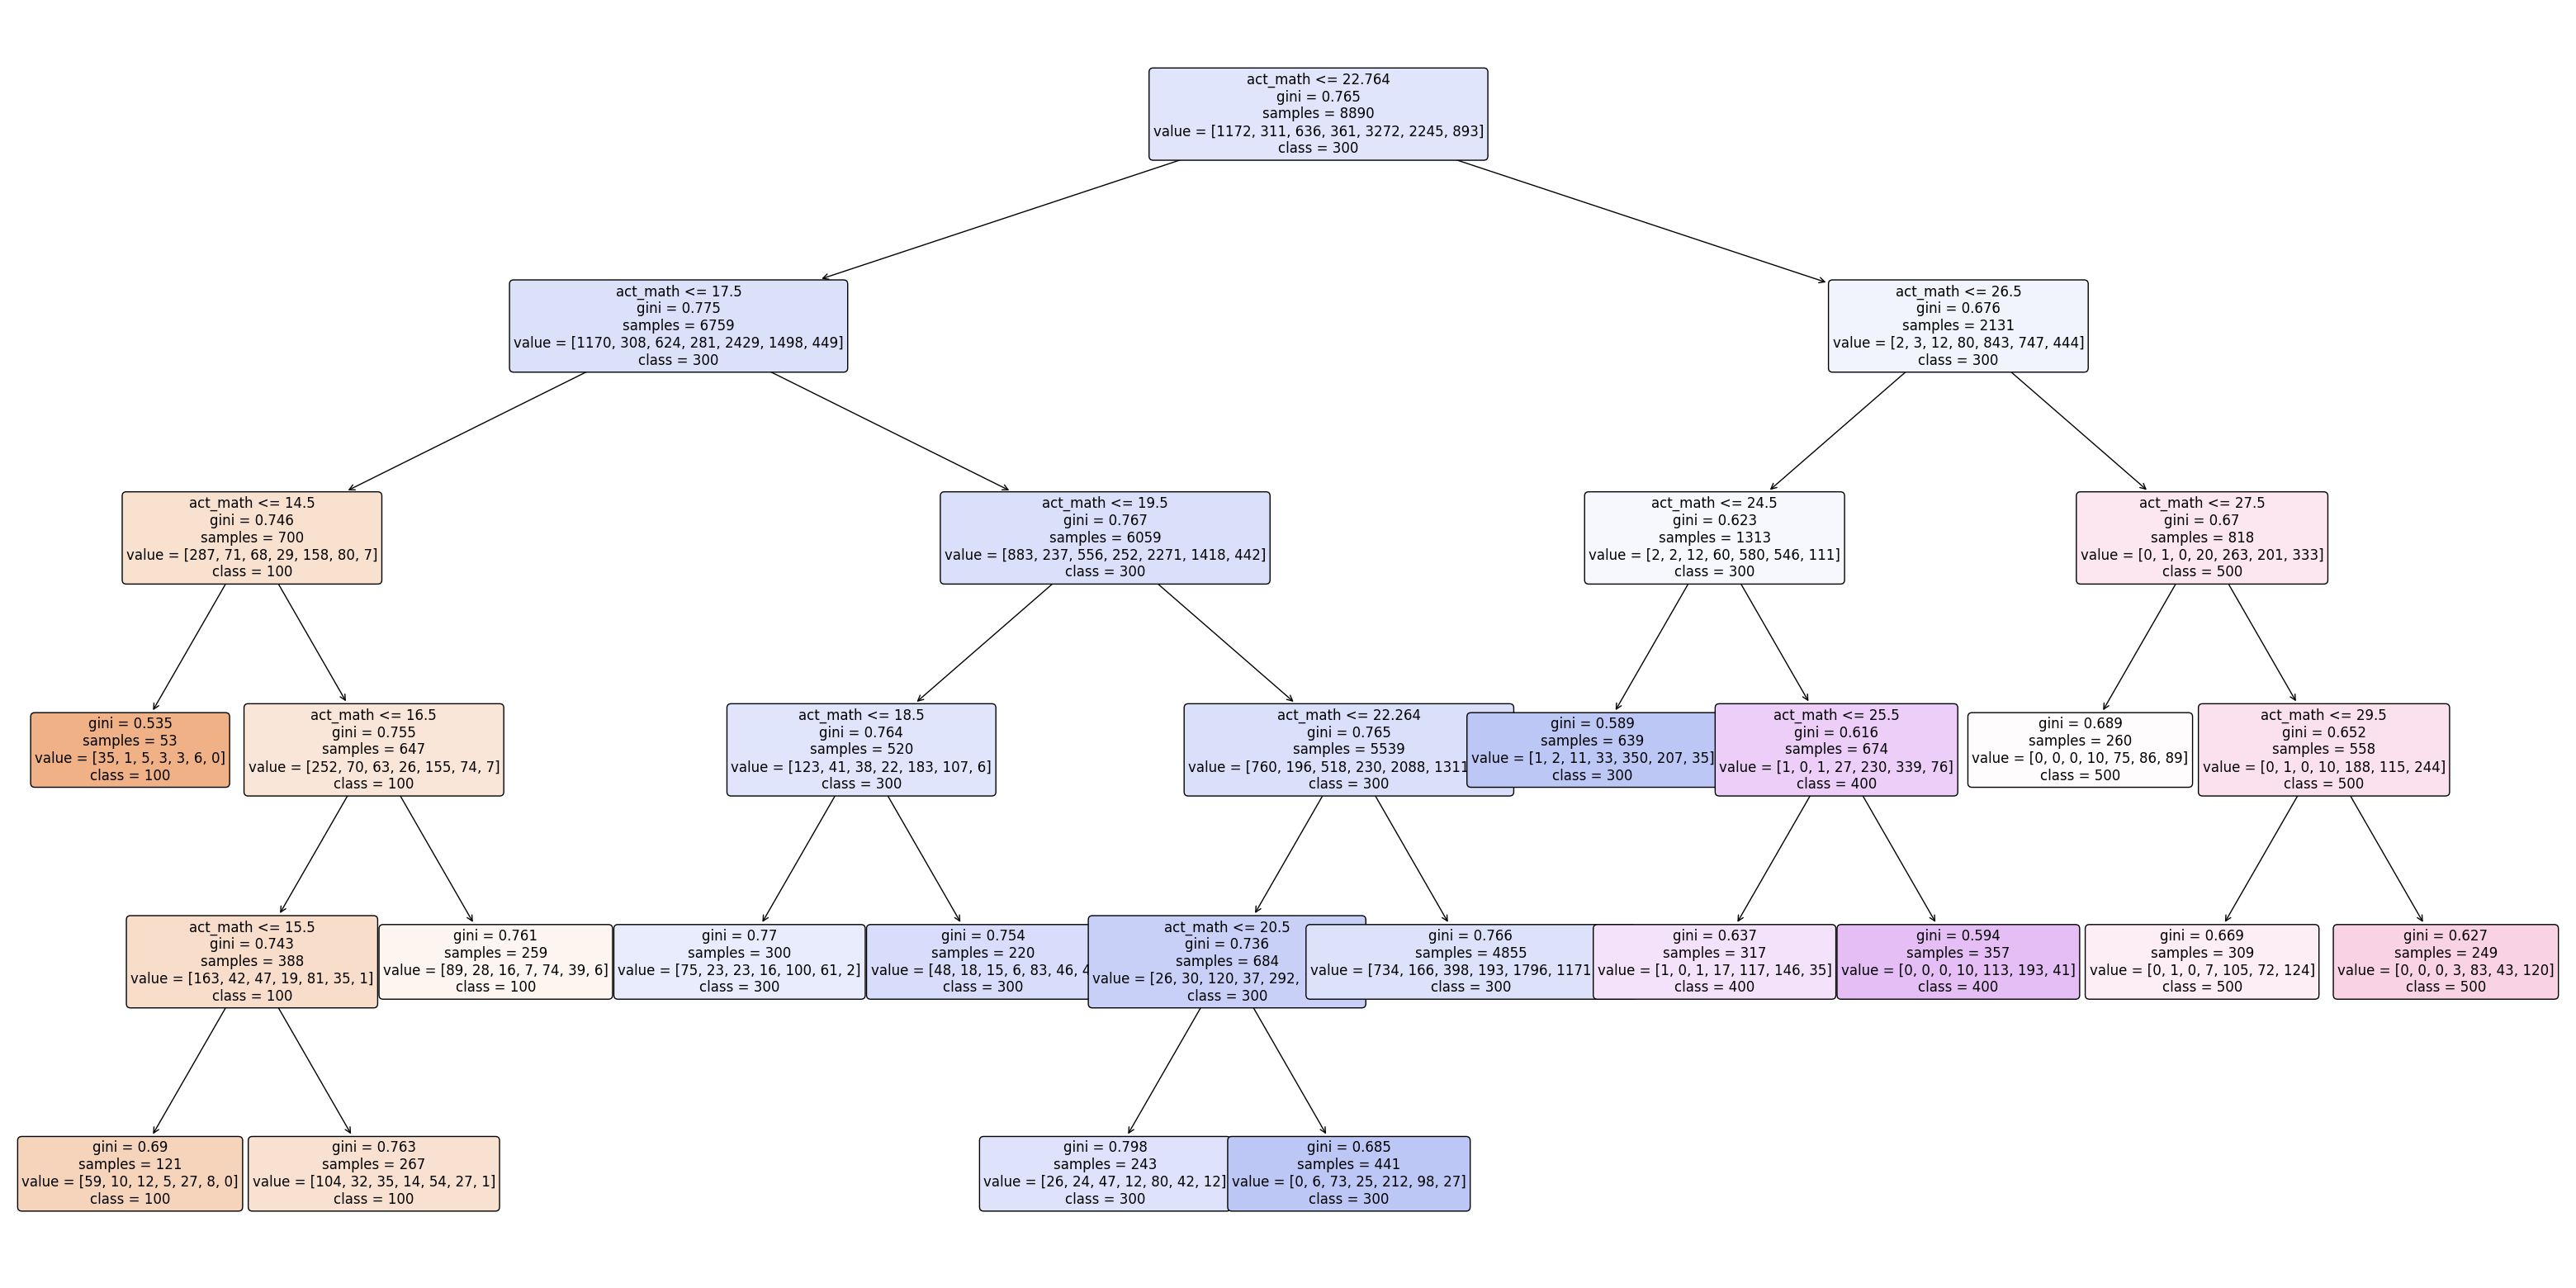

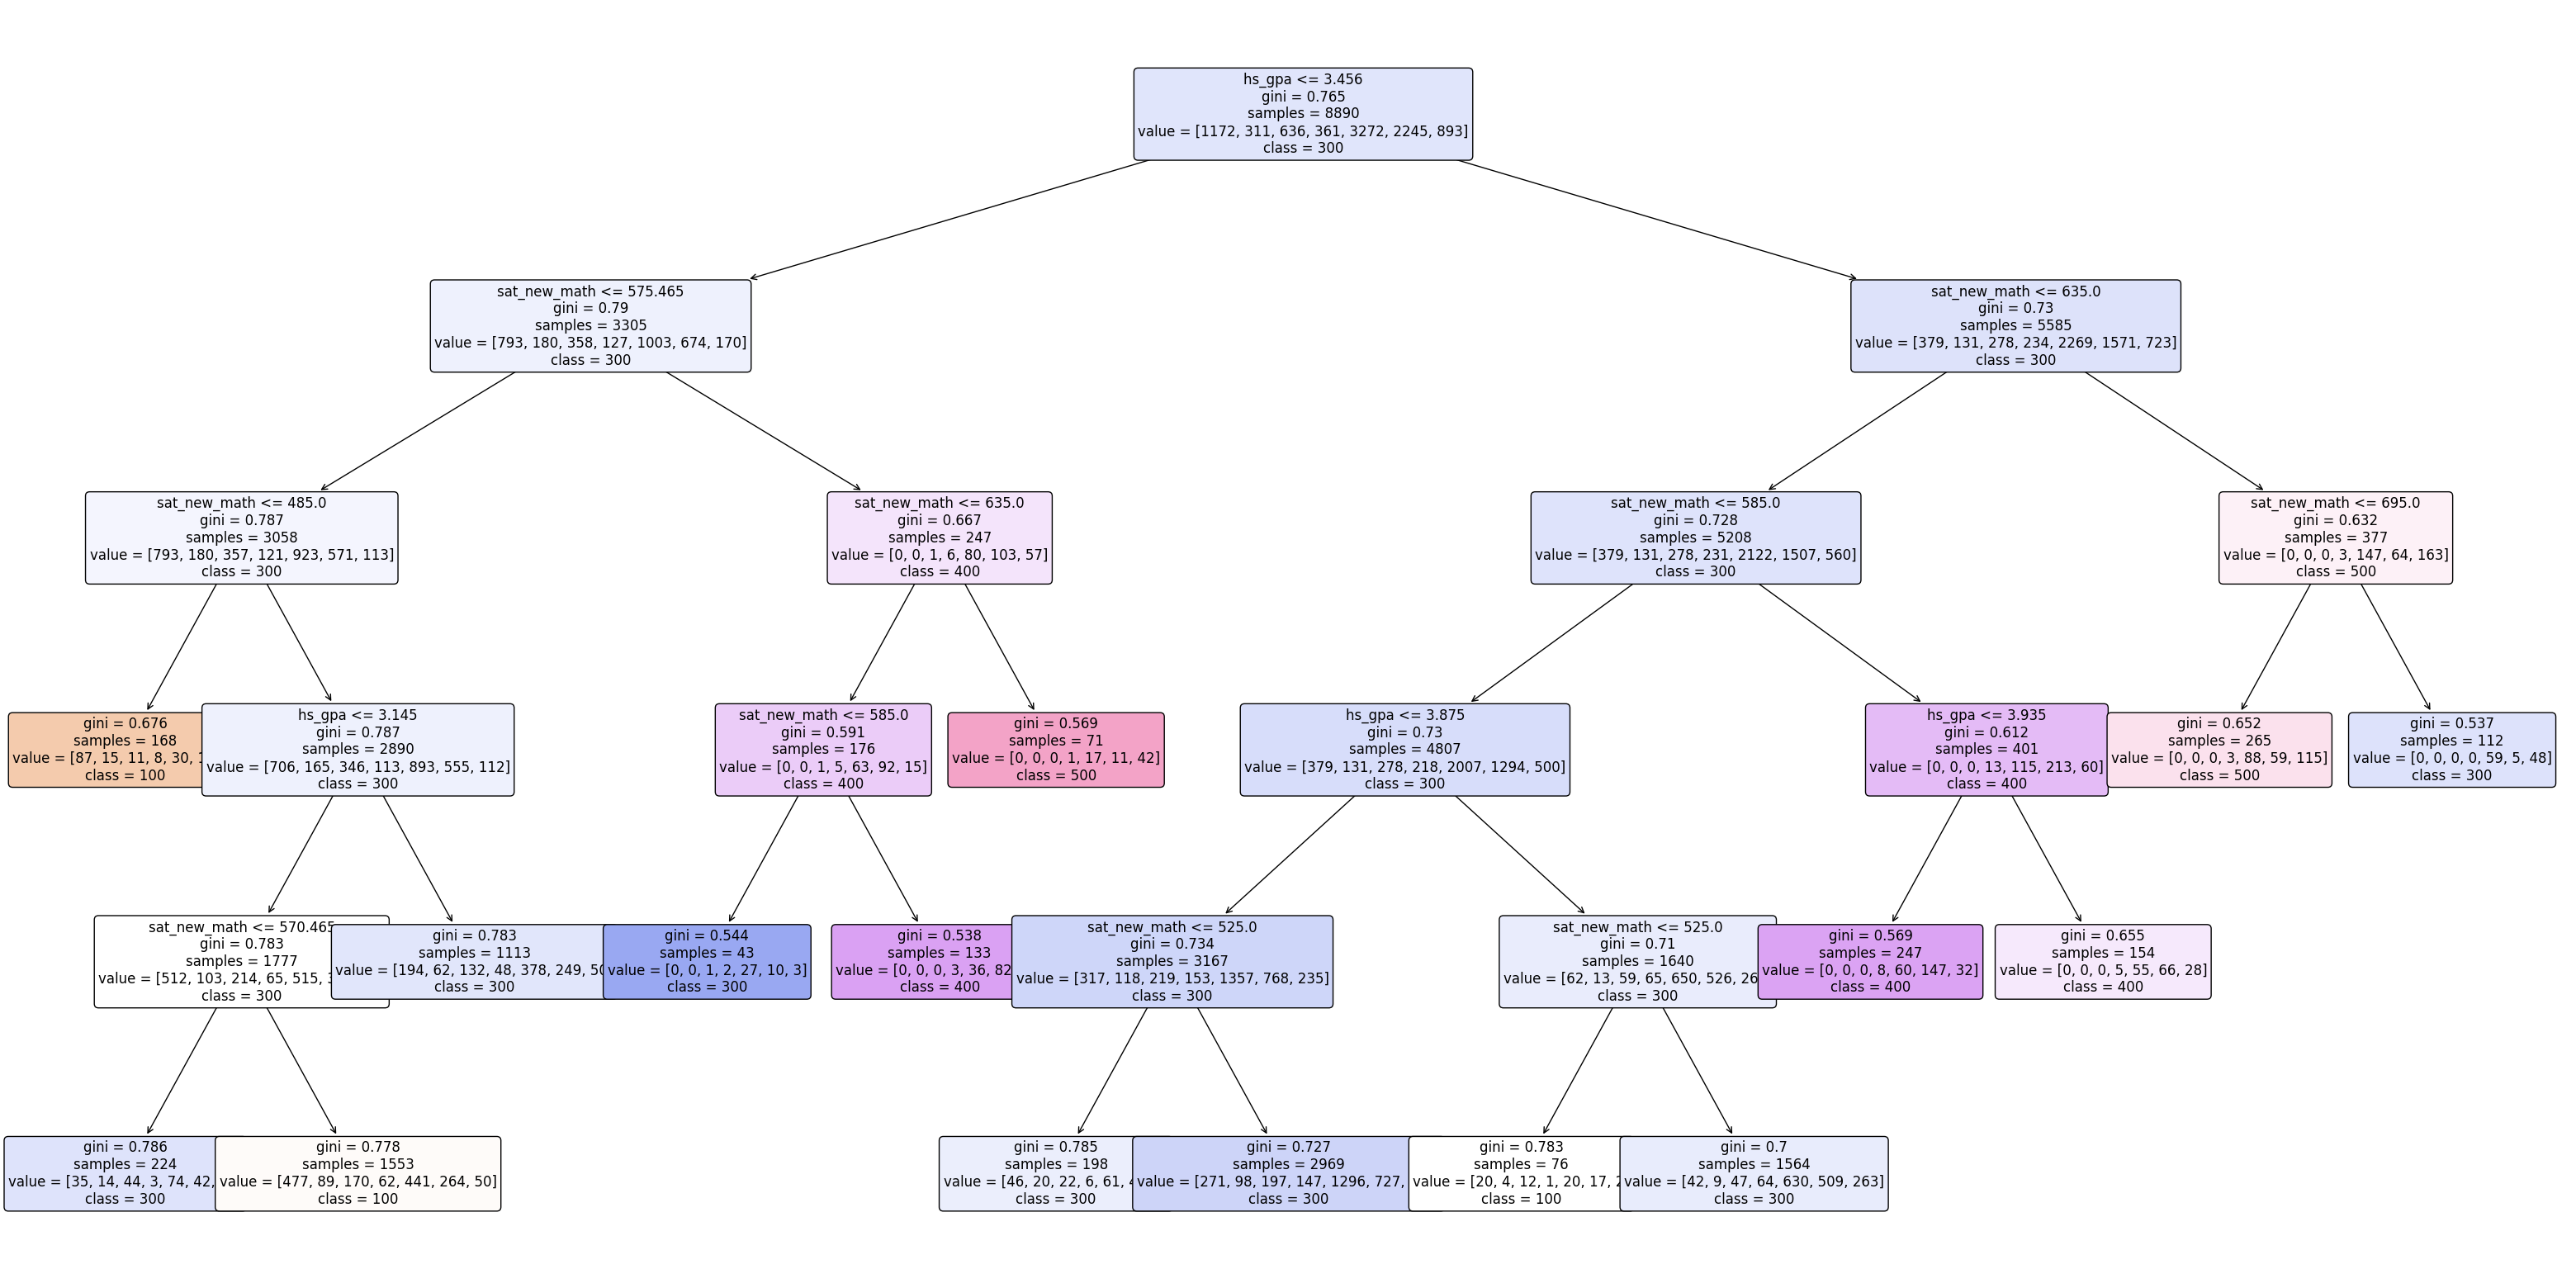

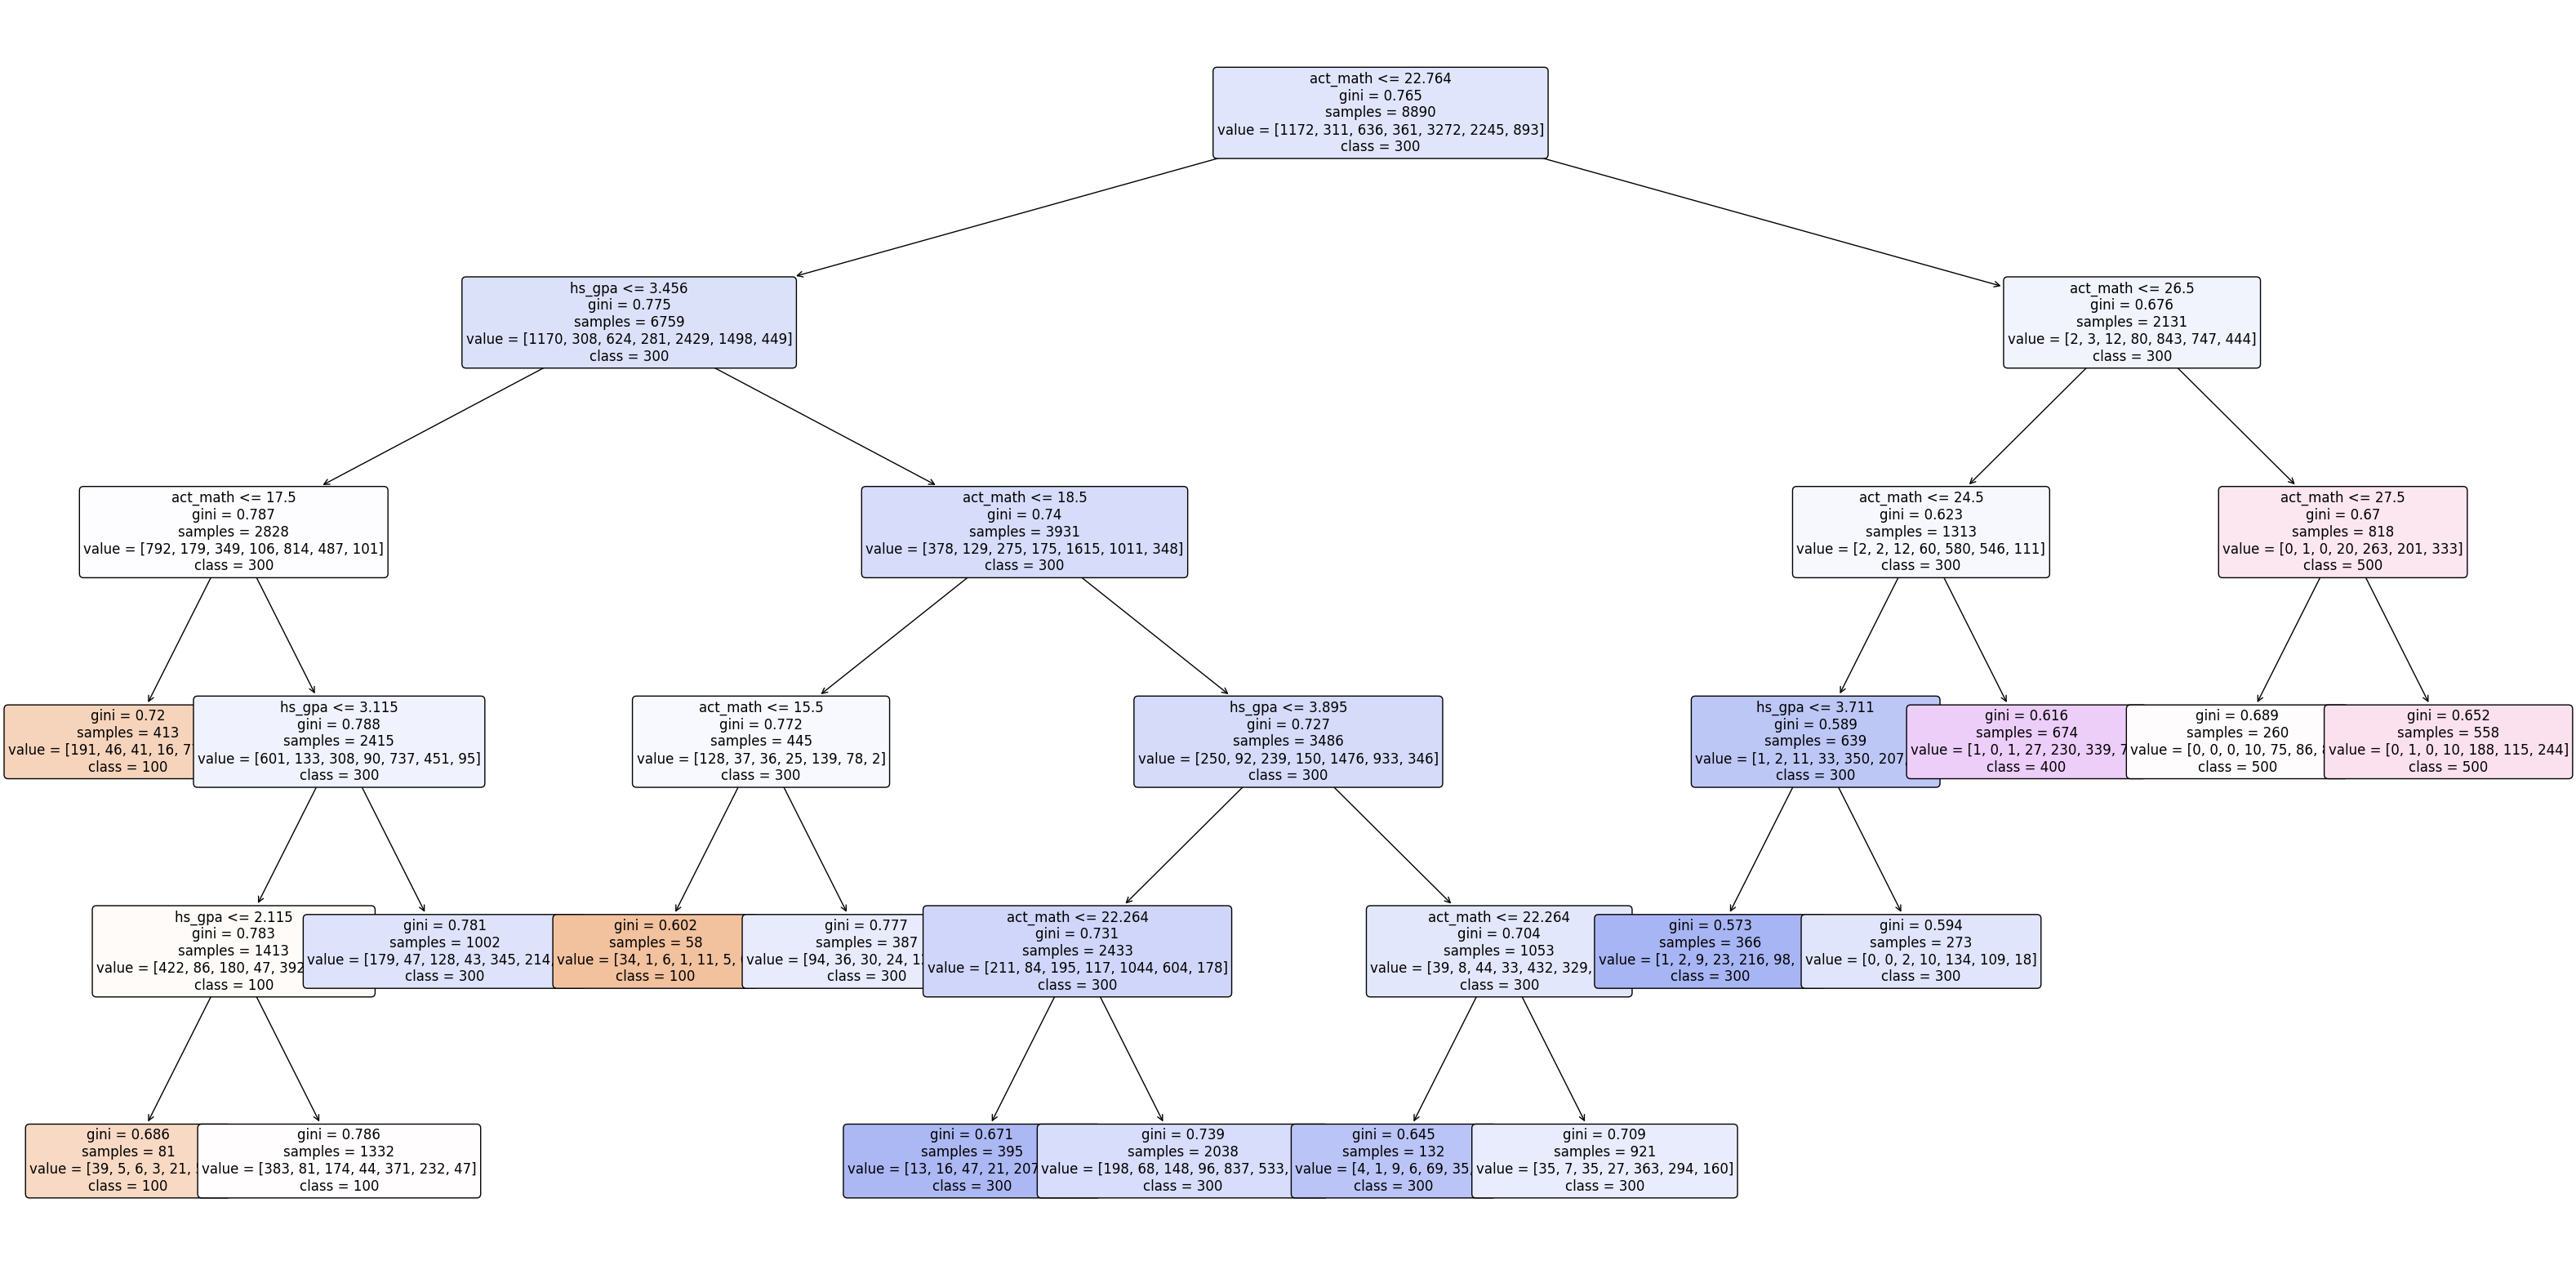

In [42]:
# Loop through each combination of predictor variables
for predictors in x_variable_combinations:
    # Predictors
    X = df_comp_copy[predictors]

    # Target variable is 'course_number_encoded'
    y_course_number = df_comp_copy['encoded_course_level']

    # Create an instance of SimpleImputer with strategy='mean'
    imputer = SimpleImputer(strategy='mean')

    # Replace NA values with the mean of each column
    X = imputer.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train_course_number, y_test_course_number = train_test_split(X, y_course_number, test_size=0.3
                                                                                    , random_state=42)

    # Fit the classifier to the training data
    clf_course_number.fit(X_train, y_train_course_number)

    # Visualize the decision tree
    plt.figure(figsize=(40, 20))
    plot_tree(clf_course_number, 
              feature_names=predictors,  # Pass feature names based on current combination
              class_names=course_number_encoder.classes_.astype(str),  # Ensure class names are strings
              filled=True, rounded=True, 
              fontsize=12)

    # Display the figure
    plt.show()

## Model 3: Random Forest

In [49]:


# Define the list of variable combinations
x_variable_combinations = [
    ['ERM_SCORE'],
    ['hs_gpa', 'ERM_SCORE'],
    ['sat_new_math'],
    ['act_math'],
    ['hs_gpa', 'sat_new_math'],
    ['hs_gpa', 'act_math']
]

# Initialize dictionaries to store model performance and models
model_performance = {}
models = {}

# Loop over each combination
for variables in x_variable_combinations:
    X = df_comp[variables].fillna(0)  # Assuming simple fillna for missing values. Use KNN imputer or other methods as necessary.
    y = df_comp['course_level']  # Ensure this is your target variable, encoded as binary or multiclass numeric labels as necessary.
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize and train the RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Print classification report
    print(f"Classification report for variables: {variables}")
    print(classification_report(y_test, y_pred, zero_division=1))
    
    # Print feature importances for the current model
    feature_importances = pd.Series(clf.feature_importances_, index=variables)
    print("Feature Importances:")
    print(feature_importances.sort_values(ascending=False))
    print("\n")

    # Calculate F1 Score and store the model
    report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    model_performance[' & '.join(variables)] = f1_score
    models[' & '.join(variables)] = clf

# Print a summary of model performance
print("Model Performance Summary:")
for combo, performance in model_performance.items():
    print(f"{combo}: F1 Score = {performance:.2f}")



Classification report for variables: ['ERM_SCORE']
              precision    recall  f1-score   support

         100       0.75      0.54      0.63       524
         150       1.00      0.00      0.00       133
         250       0.70      0.43      0.54       271
         290       1.00      0.00      0.00       163
         300       0.45      0.89      0.59      1388
         400       0.61      0.32      0.42       939
         500       1.00      0.00      0.00       393

    accuracy                           0.51      3811
   macro avg       0.79      0.31      0.31      3811
weighted avg       0.65      0.51      0.44      3811

Feature Importances:
ERM_SCORE    1.0
dtype: float64


Classification report for variables: ['hs_gpa', 'ERM_SCORE']
              precision    recall  f1-score   support

         100       0.58      0.53      0.56       524
         150       0.16      0.03      0.05       133
         250       0.60      0.41      0.49       271
         290       

## Model 4: XG Boost

In [50]:
# Convert float values in 'course_level' to integers
label_encoder = LabelEncoder()
df_comp['course_level_encoded'] = label_encoder.fit_transform(df_comp['course_level'])

# Loop through each combination of predictor variables
for predictors in x_variable_combinations:
    # Prepare the data
    X = df_comp[predictors]
    y = df_comp['course_level_encoded'] 

    # Create an instance of KNNImputer with the desired number of neighbors
    knn_imputer = KNNImputer(n_neighbors=5)  

    # Replace NA values using KNN imputation
    X_imputed = knn_imputer.fit_transform(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Continue with initializing and fitting your XGBoost classifier
    xgb_model_course_number = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_model_course_number.fit(X_train, y_train)

    # Predict on the test data
    y_pred_course_number = xgb_model_course_number.predict(X_test)

    # Decode the predicted course numbers back to the original course numbers for interpretability
    predicted_course_numbers = course_number_encoder.inverse_transform(y_pred_course_number)

    # Convert the unique encoded labels back to original string labels
    original_class_labels_str = [str(label) for label in course_number_encoder.inverse_transform(df_comp['course_level_encoded'].unique())]

    print(f"\nClassification Report {predictors}:")
    print(classification_report(y_test, y_pred_course_number, target_names=original_class_labels_str, zero_division=0))


        # Print feature importances for the current model
    feature_importances = pd.Series(xgb_model_course_number.feature_importances_, index=predictors)
    print("Feature Importances:")
    print(feature_importances.sort_values(ascending=False))
    print("\n")



C:\Users\britt\AppData\Local\Temp\ipykernel_25944\1933540153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comp['course_level_encoded'] = label_encoder.fit_transform(df_comp['course_level'])



Classification Report ['ERM_SCORE']:
              precision    recall  f1-score   support

         100       0.74      0.53      0.62       509
         300       0.00      0.00      0.00       133
         290       0.74      0.47      0.57       272
         400       0.00      0.00      0.00       157
         150       0.44      0.88      0.59      1398
         500       0.58      0.30      0.40       956
         250       0.00      0.00      0.00       386

    accuracy                           0.50      3811
   macro avg       0.36      0.31      0.31      3811
weighted avg       0.46      0.50      0.44      3811

Feature Importances:
ERM_SCORE    1.0
dtype: float32



Classification Report ['hs_gpa', 'ERM_SCORE']:
              precision    recall  f1-score   support

         100       0.61      0.58      0.59       509
         300       0.00      0.00      0.00       133
         290       0.68      0.45      0.54       272
         400       0.00      0.00      0.00  